In [53]:
import yfinance as yf
import finta as T
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
from finta import TA
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(10,5)})

[[0, 0, 'holding', 4.716178146172941, 225.05000000000007], [1, 140.76, 'vente', 4.751023452169104, 226.0900000000001], [-1, 140.76, 'achat', 4.751023452169104, 226.0900000000001]]
[[0, 0, 'holding', 4.716178146172941, 225.05000000000007], [1, 140.76, 'vente', 4.751023452169104, 226.0900000000001], [0, 140.76, 'End of strat', 4.751023452169104, 226.0900000000001]]


<AxesSubplot:title={'center':'OR.PA   rendements de notre stratégie'}, xlabel='Date'>

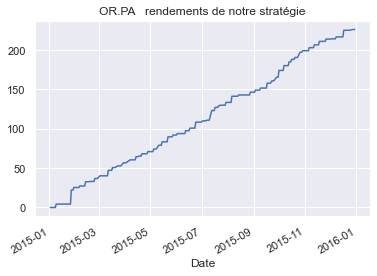

In [103]:
stock_name = "OR.PA"

stock = pd.DataFrame(yf.Ticker(stock_name).history(period="max"))
#ax = stock["Open"]["2014"].plot()
stock["up"] = stock["Open"].rolling(window=3, center = True).max()
stock["low"] = stock["Open"].rolling(window=3, center = True).min()
#stock[["up","low"]]["2014-"].plot(ax=ax)

stock["vente"] = stock["up"]-stock["Open"]
stock["vente"] = stock["vente"].apply(lambda x : int(x==0)+35)

stock["achat"] = stock["low"]-stock["Open"]
stock["achat"] = stock["achat"].apply(lambda x : -int(x==0)+35)

#stock[["achat","vente"]]["2014"].plot(ax=ax)

#stock["d_max"] = stock["d_max"].apply( lambda x : int(x>0))
#stock["d_min"] = stock["d_max"].apply( lambda x : -int(x<0))


#stock["d_max"].plot()

def apply_strategy(stock):
    stock["up"] = stock["Open"].rolling(window=3, center = True).max()
    stock["low"] = stock["Open"].rolling(window=3, center = True).min()
    
    stock["vente"] = stock["up"]-stock["Open"]
    stock["vente"] = stock["vente"].apply(lambda x : x==0)

    stock["achat"] = stock["low"]-stock["Open"]
    stock["achat"] = stock["achat"].apply(lambda x : x==0)
    l=[]
    i=0
    last_action = "achat"
    amount_ac = 0
    while not stock.iloc[i]["achat"]: 
        l.append([0,0,"Pas de prise de position",1,0])
        i+=1
    amount_ac = stock.iloc[i]["Open"]
    amount =0
    p_cent = 1
    l.append([-1, amount_ac,last_action,1,0])
    i+=1
    while i !=len(stock):
        if last_action == "achat" and stock.iloc[i]["vente"] : 
            last_action = "vente"
            p_cent = stock.iloc[i]["Open"]*p_cent/amount_ac
            amount+=stock.iloc[i]["Open"]-amount_ac
            l.append([1,amount_ac,last_action,p_cent,amount])
        elif last_action == "vente" and stock.iloc[i]["achat"]:
            amount_ac = stock.iloc[i]["Open"]
            last_action = "achat"
            l.append([-1,stock.iloc[i]["Open"],last_action,p_cent,amount])
        elif last_action=="achat" : l.append([0,0,"holding",p_cent,amount])
        elif last_action=="vente" : l.append([0,0,"waiting",p_cent,amount])
        i+=1
    
    
    j=1
    if last_action != "vente":
        while l[-j][2]  !="vente" :j+=1
        for k in range(1,j):
            l[-k]= [0,l[-j][1],"End of strat",l[-j][3],l[-j][4]]
            print(l[-4:-1])
    
    assert len(l) == len(stock), "Probleme de dim"
    assert (l[-1][2] == "End of strat" or l[-1][2] =="waiting") , "Achat final"
    assert l[-1][-1]>0 , "Stratégie perdante"
    
    stock["strat"] = np.array(l)[:,0]
    stock["strat"]=stock["strat"].astype("float64")
    
    stock["p_strat"] = np.array(l)[:,1]
    stock["p_strat"]=stock["p_strat"].astype("float64")
    
    stock["pc_strat"] = np.array(l)[:,4]
    stock["pc_strat"]=stock["pc_strat"].astype("float64")
    stock["amount"] = np.array(l)[:,4]
    stock["amount"]=stock["amount"].astype("float64")
    
 
    
    return(stock)
            
stock = apply_strategy(stock["2015"])
        
        
stock["amount"].plot(title = stock_name+"   rendements de notre stratégie")

In [105]:
stock_name = "OR.PA"
stock = pd.DataFrame(yf.Ticker(stock_name).history(period="max"))

stock_t=stock["2015"]
stock_t = apply_strategy(stock)

stock_t["bbwidth"] = TA.BBWIDTH(stock_t)
stock_t["RSI"]=TA.RSI(stock_t)
stock_t["EMA"] = TA.RSI(stock_t)
stock_t["MOM"] = TA.MOM(stock_t)

stock_t = stock_t.drop(["Dividends","Stock Splits","High","Low","Close"], axis=1)

lagmax =3
cols = ["bbwidth","RSI","EMA","MOM","strat"]
for lag in range(1,lagmax):
        for col in cols:
            stock_t[col + f"{lag} days ago"] = stock_t[col].shift(lag)

stock_t = stock_t.dropna()

X_train,y_train = stock_t.drop(["strat","vente","achat","p_strat","amount","pc_strat","up","low"], axis=1),stock_t["strat"]

In [106]:
stock_t.tail(10)

,Open,Volume,up,low,vente,achat,strat,p_strat,pc_strat,amount,...,bbwidth1 days ago,RSI1 days ago,EMA1 days ago,MOM1 days ago,strat1 days ago,bbwidth2 days ago,RSI2 days ago,EMA2 days ago,MOM2 days ago,strat2 days ago
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-12,338.95,230409,339.35,337.70,False,False,0.0,0.00,3199.17,3199.17,...,0.070452,70.449794,70.449794,20.25,1.0,0.062198,72.525308,72.525308,17.90,0.0
2021-04-13,337.70,317108,343.80,337.70,False,True,-1.0,337.70,3199.17,3199.17,...,0.075912,67.989984,67.989984,14.40,0.0,0.070452,70.449794,70.449794,20.25,1.0
2021-04-14,343.80,328042,343.80,337.70,True,False,1.0,337.70,3205.27,3205.27,...,0.083706,70.420433,70.420433,16.45,-1.0,0.075912,67.989984,67.989984,14.40,0.0
2021-04-15,339.60,352134,343.80,336.00,False,False,0.0,0.00,3205.27,3205.27,...,0.087936,68.706462,68.706462,12.55,1.0,0.083706,70.420433,70.420433,16.45,-1.0
2021-04-16,336.00,633124,339.60,336.00,False,True,-1.0,336.00,3205.27,3205.27,...,0.095288,71.713376,71.713376,15.00,0.0,0.087936,68.706462,68.706462,12.55,1.0
2021-04-19,336.50,318467,339.05,336.00,False,False,0.0,0.00,3205.27,3205.27,...,0.096873,60.919140,60.919140,9.75,-1.0,0.095288,71.713376,71.713376,15.00,0.0
2021-04-20,339.05,433745,339.05,336.50,True,False,1.0,336.00,3208.32,3208.32,...,0.097301,63.119153,63.119153,15.00,0.0,0.096873,60.919140,60.919140,9.75,-1.0
2021-04-21,337.35,404622,342.70,337.35,False,True,-1.0,337.35,3208.32,3208.32,...,0.094606,61.105843,61.105843,6.45,1.0,0.097301,63.119153,63.119153,15.00,0.0
2021-04-22,342.70,387005,348.75,337.35,False,False,0.0,0.00,3208.32,3208.32,...,0.094212,65.804399,65.804399,11.90,-1.0,0.094606,61.105843,61.105843,6.45,1.0


In [107]:
from sklearn.ensemble import RandomForestClassifier

In [108]:
stock=stock["2016"]
stock = apply_strategy(stock)

stock["bbwidth"] = TA.BBWIDTH(stock)
stock["RSI"]=TA.RSI(stock)
stock["EMA"] = TA.RSI(stock)
stock["MOM"] = TA.MOM(stock)

stock = stock.drop(["Dividends","Stock Splits","High","Low","Close"], axis=1)

lagmax =3
cols = ["bbwidth","RSI","EMA","MOM","strat"]
for lag in range(1,lagmax):
        for col in cols:
            stock[col + f"{lag} days ago"] = stock[col].shift(lag)



stock = stock.dropna()

X_test,y_test = stock.drop(["strat","vente","achat","p_strat","amount","pc_strat","up","low"], axis=1),stock["strat"]

[[1, 156.7, 'vente', 3.576076333390646, 188.08], [0, 0, 'waiting', 3.576076333390646, 188.08], [-1, 158.22, 'achat', 3.576076333390646, 188.08]]
[[1, 156.7, 'vente', 3.576076333390646, 188.08], [0, 0, 'waiting', 3.576076333390646, 188.08], [0, 156.7, 'End of strat', 3.576076333390646, 188.08]]
[[1, 156.7, 'vente', 3.576076333390646, 188.08], [0, 156.7, 'End of strat', 3.576076333390646, 188.08], [0, 156.7, 'End of strat', 3.576076333390646, 188.08]]


In [109]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [110]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9659574468085106


No handles with labels found to put in legend.


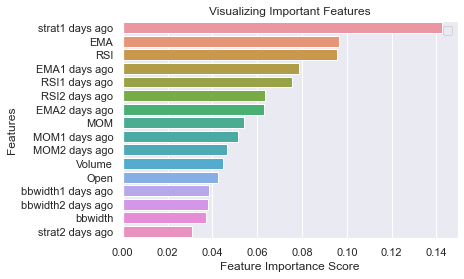

In [111]:
feature_imp = pd.Series(model.feature_importances_,index=X_test.columns).sort_values(ascending=False)
feature_imp
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

No handles with labels found to put in legend.


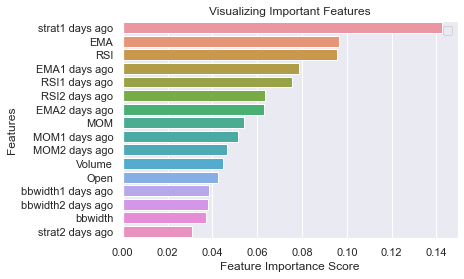

In [112]:
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

<AxesSubplot:xlabel='Date'>

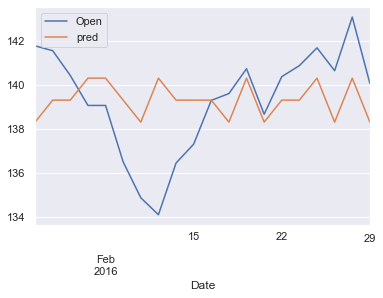

In [113]:
#plt.plot(y_pred)
#plt.plot(np.array(y_test))
date = "2016-02"
X_test["pred"] = y_pred+X_test["Open"][date].mean()

X_test[["Open","pred"]][date].plot()

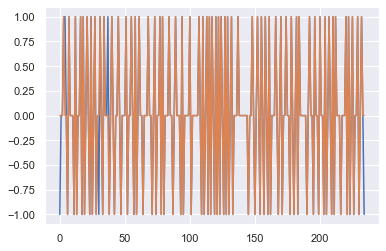

In [114]:
def pred_cleaner(strat,rank=0):
    i,j,r=0,0,0
    while strat[i]!=-1 and r==rank : 
        strat[i]=0
        i+=1
        if strat[i]==-1 : r+=1
    last_action = strat[i]
    i+=1
    while i<len(strat):
        if last_action == -1 and strat[i]==-1:
            strat[i]=0
        elif last_action==1 and strat[i]==1:
            strat[i]=0
        elif strat[i]!=0 : last_action =strat[i]
        i+=1
    while strat[-j]!=1 :
        strat[-j]=0
        j+=1
        
    return(strat)

ax = plt.plot(y_pred)
plt.plot(pred_cleaner(y_pred))


In [115]:
def rendement(Open, strat,init_acc = 100):
    l=[]
    i=0
    last_action = "achat"
    amount_ac = init_acc
    while strat[i]!=-1: 
        l.append([amount_ac,0,"Pas de prise de position"])
        i+=1
    portefeuille =  amount_ac/Open[i]
    amount_ac =0
    l.append([amount_ac, portefeuille,last_action])
    i+=1
    while i !=len(Open):
        if last_action == "achat" and strat[i]==1 : 
            last_action = "vente"
            amount_ac = Open[i]*portefeuille
            portefeuille =0
            l.append([amount_ac,portefeuille,last_action])
        elif last_action == "vente" and strat[i]==-1:
            portefeuille =  amount_ac/Open[i]
            amount_ac = 0
            last_action = "achat"
            l.append([amount_ac, portefeuille,last_action])
        elif last_action=="achat" : l.append([amount_ac,portefeuille,"holding"])
        elif last_action=="vente" : l.append([amount_ac,portefeuille,"waiting"])
        i+=1
    return(l)

        
        

In [116]:
l = rendement(list(X_test["Open"]),y_pred)
print(l[-10:-1])

[[274.1704903948193, 0, 'vente'], [0, 1.7752557005621554, 'achat'], [0, 1.7752557005621554, 'holding'], [0, 1.7752557005621554, 'holding'], [278.8394128872977, 0, 'vente'], [0, 1.7794474338691624, 'achat'], [0, 1.7794474338691624, 'holding'], [282.0246237939236, 0, 'vente'], [282.0246237939236, 0, 'waiting']]


In [117]:
import xgboost as xgb
from xgboost import XGBClassifier

In [118]:
boost = XGBClassifier()
boost.fit(X_train, y_train)
p_boost = boost.predict(X_train)
print ("Score Train -->", round(boost.score(X_train, y_train) *100,2), " %")


[21:51:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Score Train --> 99.23  %


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

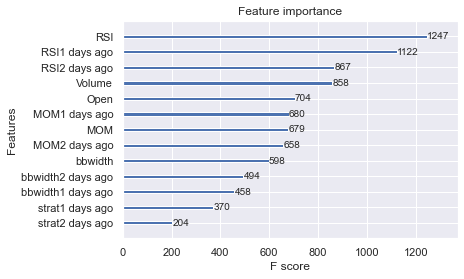

In [119]:
xgb.plot_importance(boost)